## Imports

In [1]:
!pip install rasterio

In [2]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import re
import numpy
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import random


import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import to_tensor
import random
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from math import cos,pi
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, confusion_matrix
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d
from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os
import rasterio
from glob import glob
import matplotlib.pyplot as plt
from rasterio.plot import show
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import math

import os
import numpy as np
import torch
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import random_split

from torch.utils.data import ConcatDataset, DataLoader

from scipy.stats import mode

import os
import numpy as np
import tifffile
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.stats import skew, kurtosis
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
BASE_PATH = '/kaggle/input/sentinel2-crop-mapping'
FOLDERS = ['lombardia', 'lombardia2']
YEARS = ['data2016', 'data2017', 'data2018']
IMG_SIZE = (48, 48)
BANDS = 9

def is_valid_image(file):
    return file.endswith('.tif') and '_MSAVI' not in file and os.path.basename(file) != 'y.tif'

def load_image_stack(tile_path):
    # Load and stack all satellite images (ignore MSAVI)
    img_files = sorted([f for f in os.listdir(tile_path) if is_valid_image(f)])
    stack = []
    for f in img_files:
        with rasterio.open(os.path.join(tile_path, f)) as src:
            arr = src.read()  # shape: (9, 48, 48)
            stack.append(arr)
    return np.stack(stack)  # shape: (T, 9, 48, 48)

def load_mask(tile_path):
    y_path = os.path.join(tile_path, 'y.tif')
    with rasterio.open(y_path) as src:
        mask = src.read(1)
    return remap_labels(mask, label_remap) #(48,48) image with remapped labels


In [4]:
label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

def remap_labels(mask, label_remap):
    return np.vectorize(lambda x: label_remap.get(x, 255))(mask).astype(np.uint8)


In [5]:


def plot_band_histogram(X, band=0, timestep=0, title_prefix=""):

    band_data = X[timestep, band].flatten()
    
    plt.figure(figsize=(7, 4))
    plt.hist(band_data, bins=100, color='blue', alpha=0.7)
    plt.title(f"{title_prefix} Band {band} Histogram @ t={timestep}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()






In [6]:

band_sums = np.zeros(BANDS, dtype=np.float64)
band_sqsums = np.zeros(BANDS, dtype=np.float64)
band_counts = np.zeros(BANDS, dtype=np.int64)
all_data = []

for region in FOLDERS:
    for year in YEARS:
        tiles_root = os.path.join(BASE_PATH, region, year)
        tile_ids = sorted(os.listdir(tiles_root))

        for tile_id in tqdm(tile_ids[:2500:250], desc=f"{region}/{year}"):
            tile_path = os.path.join(tiles_root, tile_id)
            try:
                X = load_image_stack(tile_path)  # (T, 9, 48, 48)
                y = load_mask(tile_path)        # (48, 48)
                
                # Compute stats
                for b in range(BANDS):
                    band_data = X[:, b, :, :].astype(np.float64)
                    band_sums[b] += band_data.sum()
                    band_sqsums[b] += (band_data ** 2).sum()
                    band_counts[b] += band_data.size

                all_data.append((X, y))
            except Exception as e:
                print(f"❌ Failed to load {tile_path}: {e}")

# mean and std
means = band_sums / band_counts
stds = np.sqrt(band_sqsums / band_counts - means ** 2)
print("\n📊 Per-band means:", np.round(means, 2))
print("📊 Per-band stds: ", np.round(stds, 2))




lombardia2/data2018: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


📊 Per-band means: [2995.19 3067.05 3033.16 3396.33 3927.15 4157.41 4257.07 2909.9  2293.53]
📊 Per-band stds:  [3469.15 3186.37 3094.14 3039.3  2653.78 2545.37 2593.22 1489.62 1362.5 ]



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 | 8274.64  468.43 6755.00 9455.00 7977.00 8265.00 8588.00   -0.26    0.23
   1 | 7683.49  456.67 6276.00 8859.00 7356.00 7669.00 7998.25   -0.07   -0.19
   2 | 7107.09  463.16 5852.00 8306.00 6748.00 7106.00 7415.25    0.07   -0.48
   3 | 7266.61  442.02 6166.00 8256.00 6924.75 7264.00 7565.00    0.07   -0.63
   4 | 7374.47  444.94 6118.00 8564.00 7054.00 7414.00 7704.00   -0.18   -0.46
   5 | 7282.92  441.95 6042.00 8466.00 6997.00 7323.00 7610.00   -0.29   -0.28
   6 | 7493.34  435.42 6197.00 8727.00 7187.00 7501.00 7811.50   -0.23   -0.15
   7 | 5393.29  323.04 4564.00 6251.00 5156.50 5393.00 5630.00   -0.01   -0.62
   8 | 4895.02  320.77 3997.00 5704.00 4660.00 4900.00 5129.00   -0.10   -0.45


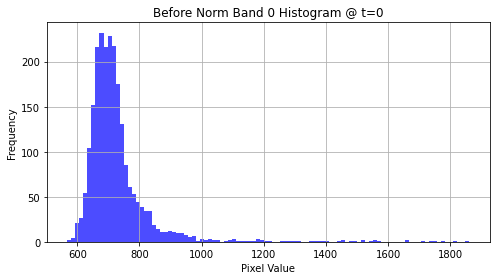

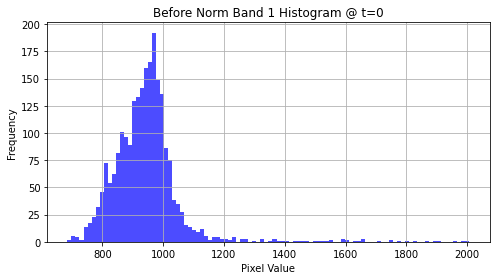

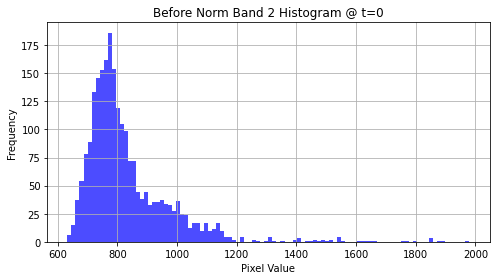

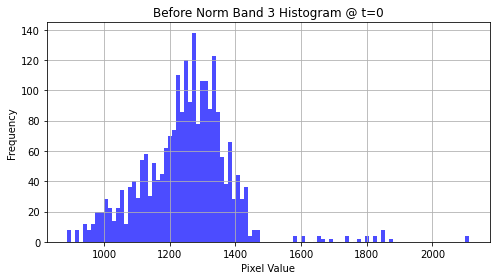

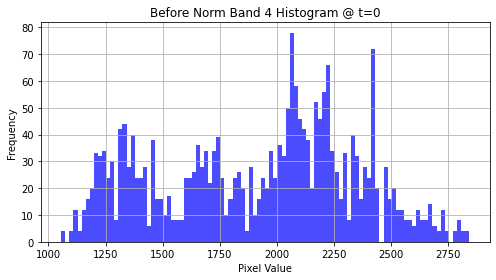

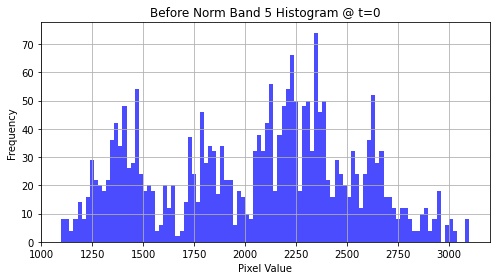

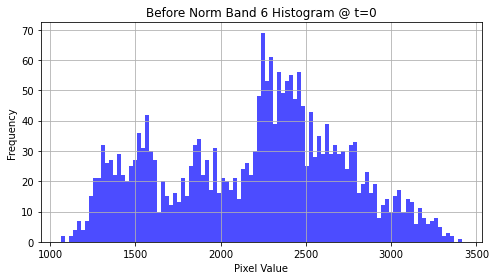

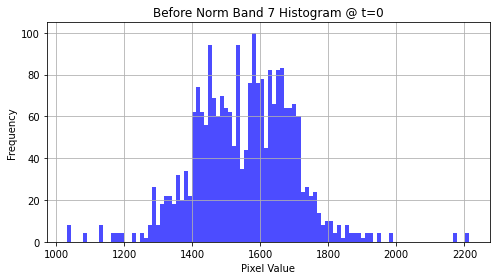

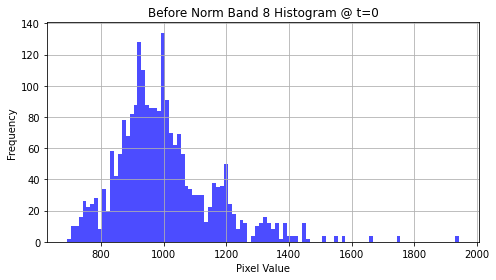

In [7]:


def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="Before Norm")

In [8]:
#Z-score normalisaiton
for i in range(len(all_data)):
    X, y = all_data[i]
    X = X.astype(np.float32)  
    for b in range(BANDS):
        X[:, b] = (X[:, b] - means[b]) / stds[b]
    all_data[i] = (X, y)



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 |    1.52    0.14    1.08    1.86    1.44    1.52    1.61   -0.26    0.23
   1 |    1.45    0.14    1.01    1.82    1.35    1.44    1.55   -0.07   -0.19
   2 |    1.32    0.15    0.91    1.70    1.20    1.32    1.42    0.07   -0.48
   3 |    1.27    0.15    0.91    1.60    1.16    1.27    1.37    0.07   -0.63
   4 |    1.30    0.17    0.83    1.75    1.18    1.31    1.42   -0.18   -0.46
   5 |    1.23    0.17    0.74    1.69    1.12    1.24    1.36   -0.29   -0.28
   6 |    1.25    0.17    0.75    1.72    1.13    1.25    1.37   -0.23   -0.15
   7 |    1.67    0.22    1.11    2.24    1.51    1.67    1.83   -0.01   -0.62
   8 |    1.91    0.24    1.25    2.50    1.74    1.91    2.08   -0.10   -0.45


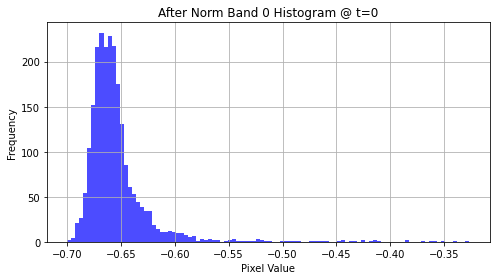

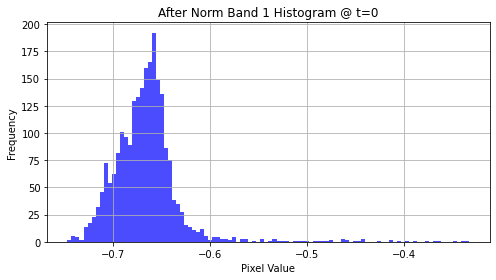

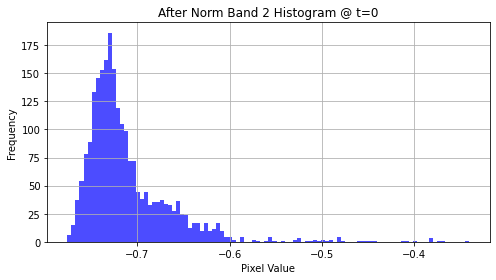

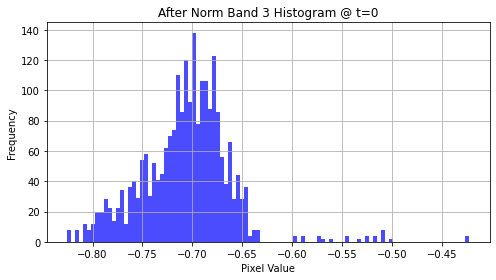

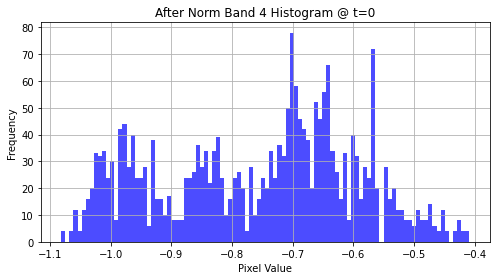

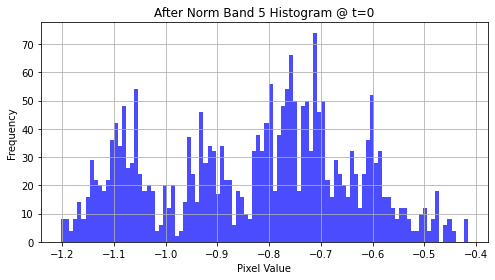

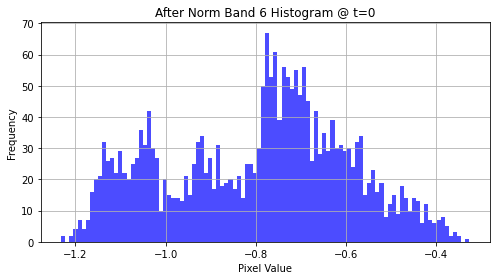

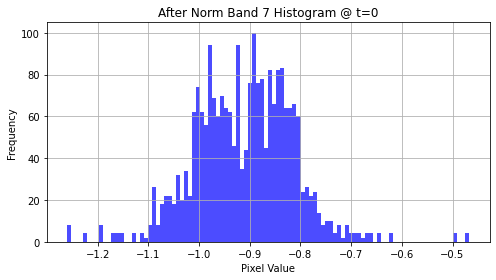

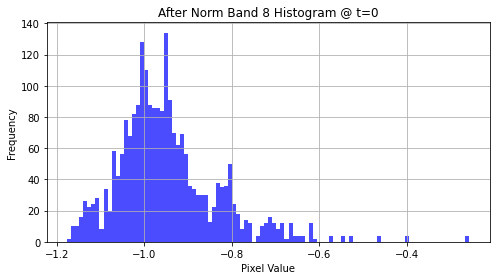

In [9]:

def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="After Norm")

In [10]:
label_counter = Counter()

for _, y in all_data:
    flat_labels = y.flatten()
    label_counter.update(flat_labels.tolist())

# Sort the label counts
label_counts = dict(sorted(label_counter.items()))

# ✅ Total number of unique labels
num_labels = len(label_counts)

# ✅ Total number of labeled pixels
total_pixels = sum(label_counts.values())



# 🔍 Print everything
print(f"🔢 Total unique labels: {num_labels}")
print(f"🧮 Total labeled pixels: {total_pixels}")
print("📊 Label Frequencies:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} pixels")

🔢 Total unique labels: 7
🧮 Total labeled pixels: 138240
📊 Label Frequencies:
  Label 0: 14794 pixels
  Label 1: 19206 pixels
  Label 2: 37036 pixels
  Label 3: 8527 pixels
  Label 4: 28835 pixels
  Label 5: 3474 pixels
  Label 6: 26368 pixels


In [11]:

label_counter = Counter()

for _, mask in all_data:
    unique, counts = np.unique(mask, return_counts=True)
    label_counter.update(dict(zip(unique, counts)))

print("Class pixel counts:", dict(label_counter))

num_classes = 7
total_pixels = sum(label_counter.values())

weights = []
for cls in range(num_classes):
    cls_count = label_counter.get(cls, 0)
    if cls_count == 0:
        weights.append(0.0)  # Unused class
    else:
        freq = cls_count / total_pixels
        weights.append(1.0 / freq)

# Step 5: Convert to torch.Tensor
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class pixel counts: {0: 14794, 1: 19206, 3: 8527, 4: 28835, 5: 3474, 6: 26368, 2: 37036}
Class weights: tensor([ 9.3443,  7.1978,  3.7326, 16.2120,  4.7942, 39.7927,  5.2427],
       device='cuda:0')


In [12]:
#fixed seed
np.random.seed(13)

#80/20 split
total_len = len(all_data)
train_len = int(0.8 * total_len)
val_len = total_len - train_len
train_raw, val_raw = random_split(all_data, [train_len, val_len])

print(f"Total samples: {len(all_data)}")
print(f"Train samples: {len(train_raw)}")
print(f"Test samples:  {len(val_raw)}")

Total samples: 60
Train samples: 48
Test samples:  12


In [13]:

def analyze_timesteps(data):
    timestep_counts = defaultdict(int)

    for X, _ in data:
        T = X.shape[0]
        timestep_counts[T] += 1

    # Print detailed info
    print("📊 Unique Time Step Counts:")
    for T in sorted(timestep_counts):
        print(f"  T = {T}: {timestep_counts[T]} tiles")

    print(f"\n🧮 Total Unique T values: {len(timestep_counts)}")
    return timestep_counts

# Example usage
analyze_timesteps(train_raw)



📊 Unique Time Step Counts:
  T = 33: 8 tiles
  T = 34: 9 tiles
  T = 53: 12 tiles
  T = 68: 10 tiles
  T = 71: 9 tiles

🧮 Total Unique T values: 5


defaultdict(int, {33: 8, 34: 9, 71: 9, 53: 12, 68: 10})

Image sequence shape: (68, 9, 48, 48)
Ground truth shape: (48, 48)


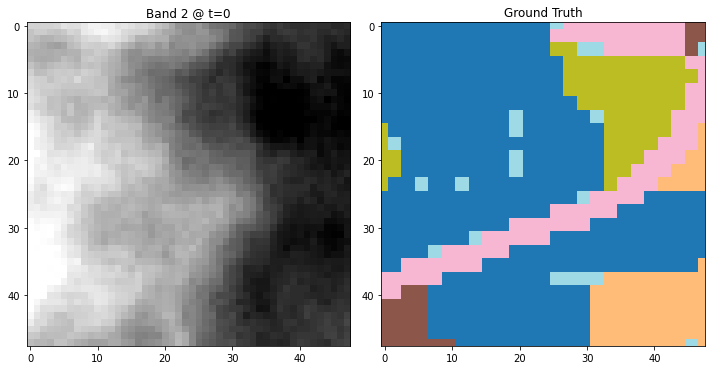

In [14]:
def plot_sample(X, y, timestep=0, band=3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    img = X[timestep, band]
    
    # Normalize visualization range to make contrast visible
    vmin = np.percentile(img, 2)
    vmax = np.percentile(img, 98)

    axs[0].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0].set_title(f'Band {band} @ t={timestep}')

    axs[1].imshow(y, cmap='tab20')
    axs[1].set_title('Ground Truth')

    plt.tight_layout()
    plt.show()


# Plot a sample
sample_X, sample_y = all_data[20]
print(f"Image sequence shape: {sample_X.shape}")  # (T, 9, 48, 48)
print(f"Ground truth shape: {sample_y.shape}")    # (48, 48)
plot_sample(sample_X, sample_y, timestep=0, band=2)


# Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilation, dropout):
        super().__init__()
        # 1×1 conv for the skip if channels change
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.main = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout2d(dropout),

            nn.Conv2d(out_ch, out_ch, 3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_ch),
            nn.Dropout2d(dropout),
            # note: final ReLU is applied after adding the skip
        )
        self.out_relu = nn.ReLU()

    def forward(self, x):
        skip = self.skip(x)
        out = self.main(x)
        return self.out_relu(out + skip)


class CNNEncoder(nn.Module):
    """Apply a stack of 5 residual blocks, producing a feature map per frame."""
    def __init__(self, in_channels=9, base_ch=256, dropout=0.3):
        super().__init__()
        # you can tune base_ch or keep the exact dims you had
        self.block1 = ResBlock(in_channels, 256, dilation=1, dropout=dropout)
        self.block2 = ResBlock(256, 256, dilation=2, dropout=dropout)
        self.block3 = ResBlock(256, 256, dilation=4, dropout=dropout)
        self.block4 = ResBlock(256, 512, dilation=2, dropout=dropout)
        self.block5 = ResBlock(512, 512, dilation=1, dropout=dropout)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x  # (B, 512, H, W)


class CNN_LSTM_Segmentation(nn.Module):
    def __init__(self, in_channels=9, lstm_hidden=64, num_classes=7, dropout=0.3):
        super().__init__()
        self.cnn_encoder = CNNEncoder(in_channels=in_channels, dropout=dropout)
        # feature dim after CNN is 512; adjust if you changed CNNEncoder
        self.feat_dim = 512  
        self.lstm = nn.LSTM(
            input_size=self.feat_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )
        # final conv to map 2*lstm_hidden → num_classes
        self.classifier = nn.Conv2d(
            in_channels=2 * lstm_hidden,
            out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        """
        x: (B, T, C, H, W)
        returns: (B, num_classes, H, W)
        """
        B, T, C, H, W = x.shape

        # 1) encode each frame
        feats = []
        for t in range(T):
            # pick out frame t: shape (B, C, H, W)
            ft = self.cnn_encoder(x[:, t])
            feats.append(ft)
        # stack → (B, T, feat_dim, H, W)
        feats = torch.stack(feats, dim=1)

        # 2) prepare for LSTM: want (B*H*W, T, feat_dim)
        # move time axis to last dims
        feats = feats.permute(0, 3, 4, 1, 2)      # (B, H, W, T, feat_dim)
        feats = feats.reshape(B * H * W, T, self.feat_dim)

        # 3) run LSTM
        lstm_out, _ = self.lstm(feats)            # (B*H*W, T, 2*lstm_hidden)
        last = lstm_out[:, -1, :]                 # (B*H*W, 2*lstm_hidden)

        # 4) reshape back to spatial map
        last = last.view(B, H, W, -1)             # (B, H, W, 2*lstm_hidden)
        last = last.permute(0, 3, 1, 2)           # (B, 2*lstm_hidden, H, W)

        # 5) final per-pixel classification
        out = self.classifier(last)               # (B, num_classes, H, W)
        return out


In [16]:
class CustomDataset(Dataset):
    def __init__(self, tiles, augment=False, noise_std=0.01):
        """
        tiles: list of (X, y) where
               X is a numpy array of shape (T, C, H, W)
               y is numpy array of shape (H, W)
        """
        self.tiles = tiles
        self.augment = augment
        self.noise_std = noise_std

        # spatial augmentations to apply per‐frame
        self.aug = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, interpolation=InterpolationMode.BILINEAR),
        ])

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        X_np, y_np = self.tiles[idx]
        # X_np: (T, C, H, W), y_np: (H, W)

        # to torch
        X = torch.from_numpy(X_np).float()     # (T, C, H, W)
        y = torch.from_numpy(y_np).long()      # (H, W)

        if self.augment:
            # apply the same random transform to each frame
            seed = torch.seed()
            frames = []
            for t in range(X.shape[0]):
                torch.manual_seed(seed)
                f = self.aug(X[t])              # (C, H, W)
                frames.append(f)
            X = torch.stack(frames, dim=0)

            # also augment the label map (treat as a 1‑channel image,
            # but beware: rotations might introduce interpolation artifacts)
            torch.manual_seed(seed)
            y = self.aug(y.unsqueeze(0)).squeeze(0).long()

        # add Gaussian noise
        X = X + torch.randn_like(X) * self.noise_std

        return X, y


def get_dataloaders(train_tiles, val_tiles, batch_size=16, timesteps=32):
    train_tiles = [(X[:timesteps], y) for X, y in train_tiles]
    val_tiles = [(X[:timesteps], y) for X, y in val_tiles]

    train_ds = CustomDataset(train_tiles, augment=True)
    val_ds = CustomDataset(val_tiles, augment=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader



# Training

In [17]:
t = 16
num_epochs = 10
lr = 1e-3
weight_decay = 1e-4
label_smoothing = 0.1

# your get_dataloaders should now return X: (B, T, C, H, W), y: (B, H, W)
train_loader, val_loader = get_dataloaders(train_raw, val_raw, batch_size=4, timesteps=t)

model = CNN_LSTM_Segmentation(
    in_channels=9,        # raw channels per frame
    lstm_hidden=64,
    num_classes=7,
    dropout=0.3
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss(weight = class_weights, label_smoothing=label_smoothing)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}"):
        # X: (B, T, C, H, W); y: (B, H, W)
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)                     # (B, num_classes, H, W)
        loss = criterion(logits, y)           # CE expects (B, C, H, W) vs (B, H, W)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(dim=1)           # (B, H, W)
        correct += (pred == y).sum().item()
        total += y.numel()

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            val_loss += loss.item()

            pred = logits.argmax(dim=1)
            val_correct += (pred == y).sum().item()
            val_total += y.numel()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)

    scheduler.step()

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
        f"Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%"
    )


[Train] Epoch 1/10: 100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


Epoch 01 | Train Loss: 2.0574 | Val Loss: 2.1797 | Train Acc: 10.35% | Val Acc: 4.52%


[Train] Epoch 2/10: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Epoch 02 | Train Loss: 2.0106 | Val Loss: 2.1972 | Train Acc: 7.97% | Val Acc: 3.62%


[Train] Epoch 3/10: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Epoch 03 | Train Loss: 1.9989 | Val Loss: 2.2169 | Train Acc: 10.99% | Val Acc: 7.37%


[Train] Epoch 4/10: 100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Epoch 04 | Train Loss: 1.9621 | Val Loss: 2.2600 | Train Acc: 9.57% | Val Acc: 1.73%


[Train] Epoch 5/10: 100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Epoch 05 | Train Loss: 1.9672 | Val Loss: 2.2138 | Train Acc: 9.87% | Val Acc: 1.94%


[Train] Epoch 6/10: 100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Epoch 06 | Train Loss: 1.9524 | Val Loss: 2.1356 | Train Acc: 9.48% | Val Acc: 5.19%


[Train] Epoch 7/10: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 07 | Train Loss: 1.9321 | Val Loss: 2.2485 | Train Acc: 10.25% | Val Acc: 3.54%


[Train] Epoch 8/10: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 08 | Train Loss: 1.9161 | Val Loss: 2.1462 | Train Acc: 11.55% | Val Acc: 11.33%


[Train] Epoch 9/10: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 09 | Train Loss: 1.9125 | Val Loss: 2.1649 | Train Acc: 11.44% | Val Acc: 6.79%


[Train] Epoch 10/10: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]
                                                                

Epoch 10 | Train Loss: 1.8785 | Val Loss: 2.1144 | Train Acc: 12.29% | Val Acc: 12.01%


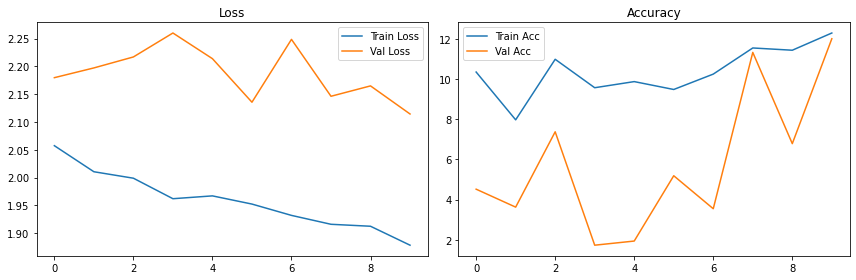

In [18]:
# --- Plotting ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evalutaion

In [19]:
def visualize(model, dataset, idx=0, num_classes=7, label_names=None, rgb_bands=(2, 1, 0), timestep=16):
    model.eval()

    # === Load data ===
    X, y = dataset[idx]           # X: (C*T, H, W), y: (H, W)
    X_input = X.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(X_input).argmax(1).squeeze().cpu().numpy()

    y = y.numpy()

    # === Reshape for RGB ===
    C = 9
    T = X.shape[0] // C
    H, W = X.shape[1], X.shape[2]

    X_vis = X.view(T, C, H, W)  # (T, C, H, W)
    rgb = X_vis[timestep][list(rgb_bands)].numpy()
    rgb = np.transpose(rgb, (1, 2, 0))
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # normalize

    # === Color Map and Legend ===
    cmap = plt.cm.get_cmap('tab10', num_classes)
    pred_classes = np.unique(pred)
    gt_classes = np.unique(y)

    pred_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in pred_classes] if label_names else []
    gt_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in gt_classes] if label_names else []

    # === Plotting ===
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Top row: Pred and GT
    axs[0, 0].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
    axs[0, 0].set_title("Predicted")
    axs[0, 0].axis("off")
    if pred_legend:
        axs[0, 0].legend(handles=pred_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    axs[0, 1].imshow(y, cmap=cmap, vmin=0, vmax=num_classes-1)
    axs[0, 1].set_title("Ground Truth")
    axs[0, 1].axis("off")
    if gt_legend:
        axs[0, 1].legend(handles=gt_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Bottom left: Satellite RGB
    axs[1, 0].imshow(rgb)
    axs[1, 0].set_title(f"Satellite RGB @ timestep {timestep}")
    axs[1, 0].axis("off")

    # Bottom right: hide unused
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()



def evaluate_combined(model, loader, label_names, num_classes=7):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=int)
    gt_counts = np.zeros(num_classes, dtype=int)
    correct = 0
    total = 0

    with torch.no_grad():
        print(f"🔍 Evaluating {len(loader.dataset)} samples")
        for X, y in loader:
            X, y = X.to(device), y.to(device)  # X: (B, 288, 48, 48), y: (B, 48, 48)
            preds = model(X).argmax(1)        # (B, 48, 48)

            preds_np = preds.cpu().numpy().flatten()
            y_np = y.cpu().numpy().flatten()

            for cls in range(num_classes):
                pred_counts[cls] += np.sum(preds_np == cls)
                gt_counts[cls] += np.sum(y_np == cls)

            correct += np.sum(preds_np == y_np)
            total += y_np.size

    print("\n📊 Ground Truth Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {gt_counts[cls]}")

    print("\n🤖 Predicted Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {pred_counts[cls]}")

    acc = correct / total
    print(f"\n✅ Per-pixel Accuracy (Total): {acc:.4f}")

    # === Plotting the distributions ===
    class_names = [label_names[cls] for cls in range(num_classes)]

    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    x = np.arange(num_classes)

    plt.bar(x - bar_width/2, gt_counts, bar_width, label='Ground Truth', color='skyblue')
    plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted', color='salmon')

    plt.xlabel("Classes")
    plt.ylabel("Pixel Count")
    plt.title("Pixel Distribution per Class")
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

label_names = {
    0: "Cereals",
    1: "Maize",
    2: "Rice",
    3: "Forage",
    4: "Unknown crop",
    5: "Woods/tree crops",
    6: "Non-agricultural"
}

val_tile = [(X[:32], y) for X, y in val_raw]
val_ds = CustomDataset(val_tile, augment=False)
visualize(model, val_ds, idx=8, num_classes=7, label_names=label_names,timestep = 16)
evaluate_combined(model, val_loader, label_names, num_classes=7)




RuntimeError: shape '[3, 9, 9, 48]' is invalid for input of size 663552

# Loading Model

In [ ]:
epoch = 10
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.to(device)
